# Auteur : Anty KOFFI 
### Notebook présentant les techniques de machine Learning pour la reconnaissance de visages propres
Les références sont marquées à la dernière cellule

In [1]:
from sklearn import datasets
import numpy as np

### Visage propres 

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Chargement du dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70)

# Recupération de la taille des images pour plot
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data  # Images vectorisées
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Nombre d'images : %d" % n_samples)
print("Chaque image fait {} par {} pixels".format(h, w))
print("Nombre de variables : %d" % n_features)
print("Nombre de classes : %d" % n_classes)
print(target_names)

image_titles = ["Image %d" % i for i in range(lfw_people.images.shape[0])]
plot_gallery(lfw_people.images, image_titles, h, w)
plt.show()

# Séparation train/test
# NE PAS CHANGER
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


Nombre d'images : 1288
Chaque image fait 62 par 47 pixels
Nombre de variables : 2914
Nombre de classes : 7
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


<Figure size 720x720 with 12 Axes>

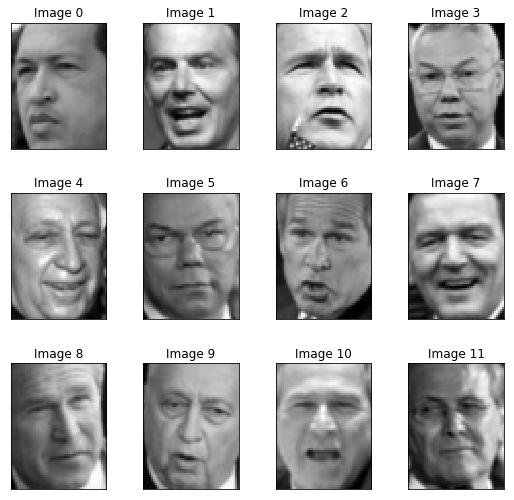

In [3]:
plot_gallery(lfw_people.images, image_titles, h, w)
plt.show()

## Preprocessing 

On suppose qu'on a accès au jeu de données de test au dernier moment. Dans ce contexte, on va se creer un jeu de validation pour evaluer et trouver les meilleurs hyperparametres de notre modele. On fait un decoupage en 80/20 de sorte à garder un maximum de données pour l'entrainement ( on a fait un test en 75/25 et les resultats sont en deça sur le jeu de test.)

In [3]:
X_app, X_val, y_app, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

##### Normalisation du jeu de données ( la séparation a été réalisée plus haut )

In [4]:
from sklearn.preprocessing import StandardScaler # Pour la normalisation

scl = StandardScaler()

## Normalisation realise à partir du jeu d'entrainement
normalize_sklearn = scl.fit(X_app) 

X_appN = normalize_sklearn.transform(X_app)
X_valN = normalize_sklearn.transform(X_val)

##### Evaluation de la dimension optimale à appliquer par PCA

Pour avoir une idée du nombre de variable à garder, on va tracer le coude d'évaluation du pourcentage de variance expliqué par rapport au nombre de dimension considéré

In [5]:
mean = np.mean(X_appN,axis = 0)
N = X_appN.shape[0]
X_bar = (X_appN - mean)

mat_cov = (X_bar.T @ X_bar)/N

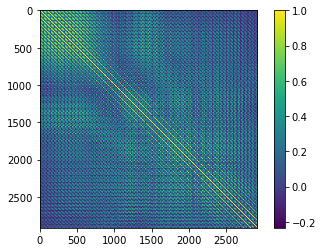

In [6]:
from matplotlib import pyplot as plt 
%matplotlib inline
plt.imshow(mat_cov)
plt.colorbar()

Le graphe comporte beaucoup de valeur jaune((cov(x1,x2) != 0)) hors de sa diagonale(variance), donc potentiellement, les valeurs ne sont pas independantes les une des autres . 

In [7]:
val_propre, vecteur_propre = np.linalg.eigh(mat_cov)

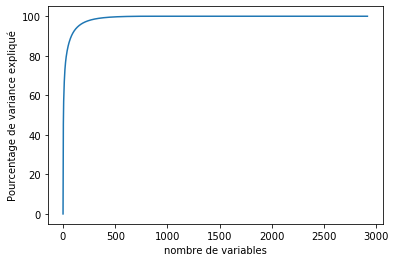

In [8]:
val_propre_sorted = val_propre[::-1] # On ordonne les valeurs propres
vecteur_propre_sorted = vecteur_propre[:,::-1] # Puis les vecteurs propres

pourcent_info = (np.cumsum(val_propre_sorted)/sum(val_propre_sorted))*100
pourcent_info = np.insert(pourcent_info,0,0)
plt.xlabel("nombre de variables")
plt.ylabel("Pourcentage de variance expliqué")
plt.plot(pourcent_info)

Il est difficile d'evaluer à l'oeil nu la rupture de pente ici. On va realiser un calcul a partir des listes dynamique :  
#####  Le critère de choix ici sera la conservation d'au moins 80 % de la variance ( la ou la courbure debute) et d'au plus 90 % de la variance.

In [9]:
type(pourcent_info)

numpy.ndarray

In [10]:
L = pourcent_info.tolist() # On transforme d'abord le vecteur pourcent_info en liste

In [11]:
len(L)

2915

In [12]:
L_trie = []  # L_trie va contenir la liste des dimensions inferieur au seil qu'on s'est fixé : 85. Elle et trié parce que pourcent_info l'était egalement

for value in L :
    if   (value <= 95) and (value >= 80) : # les bornes de 80 et 90 
        L_trie.append(L.index(value)) # L.index(value) -> recuperation de la dimension associée à une valeur de pourcentage
                                      # (suite du commentaire) et ensuite on ajoute la valeur de dimension recuperer

##### La liste L_trie est triée. Son maximum correspond à la dimension permettant de trouver la valeur de variance se rapprochant le plus du seuil.

In [13]:
dim_reducted = max(L_trie)

In [14]:
dim_reducted


147

In [15]:
L[dim_reducted] # Valeur de variance conservée

94.99169158935547

## VALIDATION : Recherche des Hyperparametres

On va essayer de determiner les hyperparametres optimaux du problème de classification. On use de trois approches : 
###### $\;\;\;\;\;\;$    Le premiere consiste a faire varier le nombre de voisin dans le knn afin de trouver celui qui maximise le score de classification. Avant de le valider par une cross-validation.
###### $\;\;\;\;\;\;$    La seconde, le gridSearch (qui a un temps d'execution exponentielle en fonction du nombre de parametre a tester ) et qui sera validé par cross-validation egalement
###### $\;\;\;\;\;\;$    La troisieme, utilise un Random GridSearch qui ressemble au GridSearch à la difference près que les hyperparametres sont selectionnees de maniere aléatoire. Une validation sera effectué par cross-validation egalement

Un resume des performances est realisee après ces calculs

In [16]:
def kppv_cross_val_score(Xn,y_train,X_testN,y_test,dim_reducted):
    
    import time
    from sklearn.model_selection import KFold # Pour la cross-validation
    from sklearn.neighbors import KNeighborsClassifier #KNN
    from sklearn.model_selection import cross_val_score

    from sklearn.decomposition import PCA
    pca = PCA(n_components=dim_reducted) #Via la methode fit_transform on applique la pca sur les données d'apprentissage : 
                                        #c'est à dire qu'on ne garde que les 47 plus grandes valeurs propres associées à
                                        #la matrice de covariance de Xa.
    pca.fit(Xn) 
    X_train_composante_principales = pca.transform(Xn) # On projete notre jeu de donnees normalisées dans le nouvelle dimension

    ## Clustering par les k-ppv


    t1 = time.time()

    k_values = [i for i in range(3,10)]
    perf = []  

    for k in k_values:
            knn = KNeighborsClassifier(k)
            knn.fit(X_train_composante_principales,y_train)
            scores = cross_val_score(knn, X_train_composante_principales, y_train, cv=3,n_jobs=-1)
            perf.append(np.mean(scores))
    best_k = k_values[np.argmax(perf)]

    print("La valeur du meilleur k sur le jeu d'entrainement :"+str(best_k)+"\n")

    # On fait l'entrainement à partir du meilleur k sur le jeu de données de dimension reduit (pour le gain de temps)

    knn = KNeighborsClassifier(best_k)
    knn.fit(X_train_composante_principales,y_train)
    score_train = knn.score(X_train_composante_principales,y_train)
    print("Performance sur le jeu de d'apprentissage :"+str(score_train)+"\n")

    # on test : si on se met dans le cas ou on vient de recevoir le jeu de test, il convient de le normaliser dans un premier temps  ! 

    X_test_composante_principales = pca.transform(X_testN)
    score_test = knn.score(X_test_composante_principales,y_test)
    print("Performance sur le jeu de test :"+str(knn.score(X_test_composante_principales,y_test)))

    t1 = time.time()- t1 
    print("temps mis : "+str(t1))
    L = []
    L.extend((t1,score_train,score_test))
    return(L,best_k)

In [17]:
L_cross_score , best_k = kppv_cross_val_score(X_appN,y_app,X_valN,y_val,dim_reducted)

La valeur du meilleur k sur le jeu d'entrainement :9

Performance sur le jeu de d'apprentissage :0.6722797927461139

Performance sur le jeu de test :0.5876288659793815
temps mis : 1.536048412322998


In [18]:
def kppv_grid_search(Xn,y_train,X_testN,y_test,dim_reducted):
    
    
        import time
        import numpy as np
        from sklearn.model_selection import KFold # Pour la cross-validation
        from sklearn.neighbors import KNeighborsClassifier #KNN
        from sklearn.model_selection import cross_val_score
        import warnings
        from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        from sklearn.decomposition import PCA


        pca = PCA(n_components=dim_reducted).fit(Xn) #Via la methode fit on applique la pca sur les données d'apprentissage : 
                                            #c'est à dire qu'on ne garde que les 153 plus grandes valeurs propres associées à
                                            #la matrice de covariance de Xn.
        X_train_composante_principales = pca.transform(Xn) # On projete notre jeu de donnees de train normalisées dans le nouvelle dimension
        X_test_composante_principales = pca.transform(X_testN)

        ## Clustering par les k-ppv



        t0 = time.time()

        grid_params = {
            'algorithm': ['brute'], # En haute dimension, l'algorithme en "force brute" est plus efficace que l'automatique
            'n_neighbors':  np.arange(3,20,1), 
            'weights': ['distance','uniform'],
            'metric': ['manhattan','minkowski']        # On force l'algorithme à faire ces tests sur ces distance. Pourquoi? Parce qu'on sait que 
                                           # la distance euclidienne ( on l'a testé) est peu efficace en haute dimension. Mais aussi, pour gagner du temps 
                                           # d'entrainement
        }

        gs = GridSearchCV(
                            KNeighborsClassifier(),
                            grid_params,
                            verbose = 1,
                            cv = 5, #Plus ce nombre est haut, plus on split le paquet de données en echantillon. Une trop grosse valeur va donc entrainer un 
                                    #grand nombre de calcul. Mais aussi, de trop petits echantillons
                            n_jobs = -1 # Ce parametre permet d'acceler le calcul par utilisation de tout les processeurs pour paralelliser le calcul
        )

        gs_results = gs.fit(X_train_composante_principales,y_train)

        t0 = time.time() - t0 
        score_train_gs = gs_results.best_score_
        print("Performance sur le jeu de d'apprentissage :"+str(score_train_gs)+"\n")
        # on test 
        score_test_gs = gs_results.score(X_test_composante_principales,y_test)
        print("Performance sur le jeu de test :"+str(score_test_gs)+"\n")

        print("temps mis : "+str(t0))
        L = []
        L.extend((t0,score_train_gs,score_test_gs))
        return(L,gs_results)

In [19]:
L_gs,gs_results = kppv_grid_search(X_appN,y_app,X_valN,y_val,dim_reducted)

Fitting 5 folds for each of 68 candidates, totalling 340 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Performance sur le jeu de d'apprentissage :0.667098445595855

Performance sur le jeu de test :0.7268041237113402

temps mis : 25.700717449188232


[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:   25.6s finished
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
def kppv_random_search(Xn,y_train,X_testN,y_test,dim_reducted):
    
    
        import time
        import numpy as np
        from sklearn.model_selection import KFold # Pour la cross-validation
        from sklearn.neighbors import KNeighborsClassifier #KNN
        from sklearn.model_selection import cross_val_score
        import warnings
        from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        from sklearn.decomposition import PCA


        pca = PCA(n_components=dim_reducted).fit(Xn) #Via la methode fit on applique la pca sur les données d'apprentissage : 
                                            #c'est à dire qu'on ne garde que les 153 plus grandes valeurs propres associées à
                                            #la matrice de covariance de Xn.
        X_train_composante_principales = pca.transform(Xn) # On projete notre jeu de donnees de train normalisées dans le nouvelle dimension
        X_test_composante_principales = pca.transform(X_testN)

        ## Clustering par les k-ppv



        t0 = time.time()

        grid_params = {
            'algorithm': ['brute'], # En haute dimension, l'algorithme en "force brute" est plus efficace que l'automatique
            'n_neighbors':  np.arange(3,20,1), 
            'weights': ['distance','uniform'],
            'metric': ['manhattan','minkowski']        # On force l'algorithme à faire ces tests sur ces distance. Pourquoi? Parce qu'on sait que 
                                           # la distance euclidienne ( on l'a testé) est peu efficace en haute dimension. Mais aussi, pour gagner du temps 
                                           # d'entrainement
        }

        gs = RandomizedSearchCV(
                            KNeighborsClassifier(),
                            grid_params,
                            verbose = 1,
                            cv = 5, #Plus ce nombre est haut, plus on split le paquet de données en echantillon. Une trop grosse valeur va donc entrainer un 
                                    #grand nombre de calcul. Mais aussi, de trop petits echantillons
                            n_jobs = -1 # Ce parametre permet d'acceler le calcul par utilisation de tout les processeurs pour paralelliser le calcul
        )

        gs_results_random = gs.fit(X_train_composante_principales,y_train)

        t0 = time.time() - t0 
        score_train_gs = gs_results_random.best_score_
        print("Performance sur le jeu de d'apprentissage :"+str(score_train_gs)+"\n")
        # on test 
        score_test_gs = gs_results_random.score(X_test_composante_principales,y_test)
        print("Performance sur le jeu de test :"+str(score_test_gs)+"\n")

        print("temps mis : "+str(t0))
        L = []
        L.extend((t0,score_train_gs,score_test_gs))
        return(L,gs_results)

In [21]:
L_gs_random,gs_results_random = kppv_random_search(X_appN,y_app,X_valN,y_val,dim_reducted)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Performance sur le jeu de d'apprentissage :0.6463730569948186

Performance sur le jeu de test :0.7319587628865979

temps mis : 2.9160075187683105


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Resume PCA lineaire sur le jeu de validation

In [22]:
import pandas as pd 

header = ["PCA_GS", "PCA_cross_val_score","PCA_random_Search"]
techniques = ["Cross_val_score","GridSearch","RandomSearch"]
df = pd.DataFrame(list(zip(L_gs,L_cross_score,L_gs_random)),columns=header,index=["temps","train score","test score"])


In [23]:
df

,PCA_GS,PCA_cross_val_score,PCA_random_Search
temps,25.700717,1.536048,2.916008
train score,0.667098,0.672280,0.646373
test score,0.726804,0.587629,0.731959


 1-  PCA_cross_val_score 
 
 il est difficile de bidouiller les valeurs d'hyperparametres interagissant de sorte à trouver un optimum : quelle metrique utilisée ? Quel type de poids (weights) utilisé? . C'est la raison principale qui m'a poussé à me tourner vers le gridSearch qui se charge automatiquement de trouver les meilleurs combinaisons d'hyperparametres.
 
 2- PCA_GS 
 
 En mon sens, il est essentiel de posseder un certain nombre d'informations sur la nature des variables a manipuler. faute de quoi, ce type recherche d'hyperparametre prendrait trop de temps vu que l'algorithme doit parcourir enormement de chemin(temps exponentielle par rapport aux variables testées) pour deduire un bonne combinaison.
Cela dit, cela reste la méthode la plus sûr de trouver les meilleurs hyperparametres. Par la suite, on pourrait directement user de ces parametres optimaux pour entrainer le modele et gagner du temps ! 
 
3- PCA_Random_Search

Le principe est le même qu'avec le Grid Search à la difference que le choix des hyperparamêtres se fait de manière aléatoire. En conséquence, le temps de recherche d'hyperparametre est divisé par 10 et le resultat sur le test est très proche, parfois même meilleur. 

### Les parametres optimaux utilisées sur le jeu de validation trouvés par le gridsearch

In [24]:
gs_results.best_params_

{'algorithm': 'brute',
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'distance'}

### Les parametres optimaux utilisées sur le jeu de validation trouvés par le RandomSearch

In [30]:
gs_results_random.best_params_

{'algorithm': 'brute',
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'distance'}

# TEST 

In [26]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

from sklearn.preprocessing import StandardScaler # Pour la normalisation

scl = StandardScaler()

## Normalisation realise à partir du jeu d'entrainement
normalize_sklearn = scl.fit(X_train) 
X_trainN = normalize_sklearn.transform(X_train)
X_testN = scl.transform(X_test) # Normalisation sur le jeu de test
pca = PCA(n_components=dim_reducted).fit(X_trainN) # pca sur TOUT le jeu d'apprentissage X_train : il n'est plus neccessaire
                                                 # de faire l'entrainement que sur le X_app ; on a acces a tout le jeu
X_trainN_composante_principales = pca.transform(X_trainN) # transformation du jeu de train en dimension principales
X_testN_composante_principales = pca.transform(X_testN) # transformation du jeu de test en dimension princpales 

##Classification par les kppv

## On fait le knn a partir des parametres optimaux retenus sur le jeu de validation plus haut 
t = time.time() #On declenche le chrono'

knn = KNeighborsClassifier(algorithm=gs_results_random.best_params_['algorithm'], # on utilise les parametres optimaux trouvés
                           metric=gs_results_random.best_params_['metric'],
                           n_neighbors=gs_results_random.best_params_['n_neighbors'],
                           weights=gs_results_random.best_params_['weights'])
knn.fit(X_trainN_composante_principales,y_train)

## Evaluation du score sur le jeu de test
score  = knn.score(X_testN_composante_principales,y_test)
t = time.time() - t 
print("Temps mis : "+str(t)+"\n")
print("Precision :"+str(score))


Temps mis : 0.21792149543762207

Precision :0.7142857142857143


#### On obtient environ 71% de precision de calcul sur le jeu de test apres une PCA lineaire en 0.22 seconde sur le jeu d'entrainement. 
Note : -Ce temps est très dépendant des machines sur lesquels elles tournent

       -Les resultats sont très robustes et varient très peu même en répétant l'algorithme plusieurs fois

# Technique non linéaire de reduction de dimension : UMAP

Bien que le resultat sur la projection lineaire etait satisfaisant, on va essayer d'evaluer une autre approche : la projection non-lineaire.
Cette fois, on va directement utiliser la random Search pour optimiser le modele

La raison est que selon la documentation de UMAP, cette methode possede 4 parametres : la distance utilisée(metric), 
le nombre de voisins(n_neighbors), le nombre de dimensions (n_components) et un parametre permettant de 
controler comment UMAP regroupe les données(min_dist)

C'est pourquoi, on va realiser une pipeline chainée sur le KNN et le UMAP en vue de déterminer les parametres optimaux.
On a au moins 4 parametres à faire varier et c'est pourquoi le randomSearch s'impose naturellement ( on ne vas pas refaire l'etude comparative precedente). 

#### Recherche des meilleurs hyperparametres

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier #KNN
import umap.umap_ as umap


kppv = KNeighborsClassifier()
umap = umap.UMAP(random_state=42).fit(X_appN,y_app)

random_kppv_params = {
    
    'n_neighbors':  np.arange(3,30,1),
    'metric': ['euclidean'] #Cette fois on est en faible dimension, on force l'algorithme sur cette metrique
}

pipeline = Pipeline([("umap", umap),
                    ("knn",kppv)])

params_grid_pipeline = {"umap__n_neighbors": np.arange(15,192,30), # 200 est la valeur maximale, 15 la valeur par defaut
                        "umap__min_dist" : [0.0,0.25,0.8],
                        "umap__metric":['euclidean','manhattan'],
                        "umap__n_components":[2,3,15], # 
                        "knn__n_neighbors":np.arange(3,30,1),
                        "knn__algorithm": ["auto","brute"] 
                        }

clf_pipeline = RandomizedSearchCV(pipeline, params_grid_pipeline,cv=3)# On minise ce terme vu qu'on a déja enormement de variables
clf_pipeline.fit(umap.embedding_, y_app)
clf_pipeline.score(umap.transform(X_valN), y_val)

/srv/conda/envs/notebook/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/srv/conda/envs/notebook/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/srv/conda/envs/notebook/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/srv/conda/envs/notebook/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
/srv/conda/envs/notebook/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/srv/conda/envs/notebook/lib/python3.7/s

0.5670103092783505

#### Parametres optimaux trouvés sur le jeu de validation

In [63]:
clf_pipeline.best_params_

{'umap__n_neighbors': 15,
 'umap__n_components': 15,
 'umap__min_dist': 0.0,
 'umap__metric': 'euclidean',
 'knn__n_neighbors': 3,
 'knn__algorithm': 'brute'}

In [64]:
clf_pipeline.best_score_

0.966321243523316

Parametres optimaux trouvés au bout d'une iteration : 

{'umap__n_neighbors': 15,
 'umap__n_components': 15,
 'umap__min_dist': 0.0,
 'umap__metric': 'euclidean',
 'knn__n_neighbors': 3,
 'knn__algorithm': 'brute'}

## TEST

In [74]:
import time
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler # Pour la normalisation

scl = StandardScaler()

## Normalisation realise à partir du jeu d'entrainement
normalize_sklearn = scl.fit(X_train) 
X_trainN = normalize_sklearn.transform(X_train)
X_testN = scl.transform(X_test) # Normalisation sur le jeu de test

umap = umap.UMAP(n_neighbors=clf_pipeline.best_params_['umap__n_neighbors'],
                 min_dist=clf_pipeline.best_params_['umap__min_dist'],
                 metric=clf_pipeline.best_params_['umap__metric'],
                 n_components=clf_pipeline.best_params_['umap__n_components'],
                 random_state=42).fit(X_trainN,y_train)

X_testN_umap = umap.transform(X_testN) #Projection en dimension 15 

## Classification par les kpp-v

t3 = time.time()
knn = KNeighborsClassifier(n_neighbors=clf_pipeline.best_params_['knn__n_neighbors'], # on utilise les parametres optimaux trouvés
                           algorithm=clf_pipeline.best_params_['knn__algorithm'])
knn.fit(umap.embedding_,y_train)
t3 = time.time() - t3
print("Precision sur le jeu d'entrainement : "+str(knn.score(umap.embedding_,y_train)))
print("precision sur le jeu de test : "+str(knn.score(X_testN_umap,y_test)))
print("Temps effectue : "+str(t3))

Precision sur le jeu d'entrainement : 0.9761904761904762
precision sur le jeu de test : 0.6149068322981367
Temps effectue : 0.0007255077362060547


### On a une precision en deça de la PCA. Mais ce qui est notable, c'est la perte de près de 30% de précision entre le jeu d'entrainement et le jeu de test : on overfit. 
### Par contre les resultats obtenus ne sont pas robuste. En relançant l'algorithme, on pourrait très bien tombé sur un jeu de parametres nous donnant de piètres resultats !   
### Enfin, en contre-partie de ce manque de robustesse, le temps de calcul est plus rapide qu'avec la projection par PCA : cela est probablement dû à la dimension reduit sur laquelle on travaille. 

Visualisons les clusters formés sur les deux jeux de données  : 

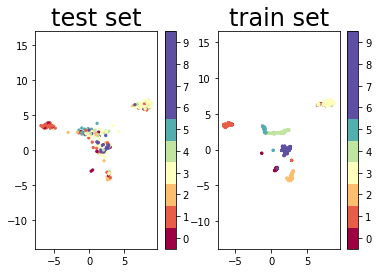

In [81]:
import numpy as np 
plt.subplot(1,2,1)

plt.scatter(X_testN_umap[:, 0], X_testN_umap[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('test set', fontsize=24);

plt.subplot(1,2,2)

plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('train set', fontsize=24);

## UMAP arrive à clusteriser correctement les données (97% environ de bonnes categorisation sur le jeu d'entrainement) mais coince plus sur les classifications

###### Reference : 

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://stats.stackexchange.com/questions/378771/cross-validation-and-train-test-split

https://umap-learn.readthedocs.io/en/latest/parameters.html

https://umap-learn.readthedocs.io/en/latest/supervised.html 

https://umap-learn.readthedocs.io/en/latest/faq.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation